In [1]:
import pyspark.sql
import sys
import os
import numpy as np
import pandas as pd
import json
import glob
from collections import Counter
import time
import matplotlib.pyplot as plt
import nltk
from simhash import Simhash, SimhashIndex
import re
import csv

In [2]:
#Connect to data
dat=spark.read.json("/user/ivy2/Tweets/*.json") #15 minutes
dat.cache()

DataFrame[contributors: string, coordinates: struct<coordinates:array<double>,type:string>, created_at: string, display_text_range: array<bigint>, entities: struct<hashtags:array<struct<indices:array<bigint>,text:string>>,media:array<struct<additional_media_info:struct<description:string,embeddable:boolean,monetizable:boolean,title:string>,description:string,display_url:string,expanded_url:string,id:bigint,id_str:string,indices:array<bigint>,media_url:string,media_url_https:string,sizes:struct<large:struct<h:bigint,resize:string,w:bigint>,medium:struct<h:bigint,resize:string,w:bigint>,small:struct<h:bigint,resize:string,w:bigint>,thumb:struct<h:bigint,resize:string,w:bigint>>,source_status_id:bigint,source_status_id_str:string,source_user_id:bigint,source_user_id_str:string,type:string,url:string>>,symbols:array<struct<indices:array<bigint>,text:string>>,urls:array<struct<display_url:string,expanded_url:string,indices:array<bigint>,url:string>>,user_mentions:array<struct<id:bigint,id_s

In [3]:
dat.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: bo

In [4]:
dat.count()

117418112

In [3]:
#*
#Below shows an example of filtering for select schools based on popular references

dat2 = dat.filter(dat.text.rlike(\
    "UniversityofChicago|UofC|UChicago|\
    PennState|PSU|PennStateUniversity|\
    RutgersUniversity|Rutgers|RU|\
    HarvardUniversity|Harvard|HU"))

In [6]:
#We have successfully reduced the data substantially:
dat2.count()

2643322

In [7]:
#FINAL EDA - save, move, load

# #We only include fields we are interested in:
# dat2_filtered=dat2.select(['created_at','user','text','retweet_count','reply_count','favorite_count'])

# #Save work 
# dat2_filtered.write.json("dat2_filtered")

# #Move to Linux cluster
# !hdfs dfs -get dat2_filtered ~/

#Load work
dat2_filtered = []
for file in os.listdir("dat2_filtered"):
    for line in open("dat2_filtered/"+file, "r", encoding="utf8"):
        dat2_filtered.append(json.loads(line))

print("Total tweet count: ",len(dat2_filtered))


Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Total tweet count:  2643322


In [19]:
#FINAL EDA - collect and report
#Extract characteristics to examine

EDA_statuses_count=[]
for i in dat2_filtered:
    try:
        EDA_statuses_count.append(i['user']['statuses_count']) 
    except:
        pass
        
EDA_screennames=[]
for i in dat2_filtered:
    try:
        EDA_screennames.append(i['user']['screen_name'])
    except:
        pass

print("Total unique tweeters: ",len(set(EDA_screennames)))    
print("Average tweets per user:", len(EDA_screennames)/len(set(EDA_screennames)))

EDA_followers=[]
for i in dat2_filtered:
    try:
        EDA_followers.append(i['user']['followers_count'])
    except:
        pass
        
print("Average & Median followers per tweet:", np.mean(EDA_followers),np.median(EDA_followers))

EDA_text=[]
for i in dat2_filtered:
    try:
        EDA_text.append(len(i['text']))
    except:
        pass
        
print("Average tweet length: ", np.mean(EDA_text))

EDA_rt=[]
for i in dat2_filtered:
    try:
        EDA_rt.append(i['retweet_count'])
    except:
        pass
        
print("Average & Median retweet count: ", np.mean(EDA_rt),np.median(EDA_rt))

EDA_ft=[]
for i in dat2_filtered:
    try:
        EDA_ft.append(i['favorite_count'])
    except:
        pass
        
print("Average & Median favorite count per tweet: ", np.mean(EDA_ft),np.median(EDA_ft))

EDA_ft2=[]
for i in dat2_filtered:
    try:
        EDA_ft2.append(i['user']['favourites_count'])
    except:
        pass
        
print("Average & Median favorites given by a tweeting user: ", np.mean(EDA_ft2),np.median(EDA_ft2))


print('\n')
print("It would seem there is no information provided by favorites or retweets info")
    

Total unique tweeters:  1527240
Average tweets per user: 1.7307836358398156
Average & Median followers per tweet: 8201.33114542988 481.0
Average tweet length:  126.67103553785729
Average & Median retweet count:  0.0 0.0
Average & Median favorite count per tweet:  0.0 0.0
Average & Median favorites given by a tweeting user:  16590.21200481818 3971.0


It would seem there is no information provided by favorites or retweets info


In [22]:
#FINAL EDA - times analysis


EDA_times=[] #initialize list of times
for i in dat2_filtered:
    EDA_times.append(i['created_at']) #fill list with times
EDA_times=pd.DataFrame(EDA_times) #dataframe it
EDA_times.columns=["created_at"] #column name
EDA_times=pd.to_datetime(EDA_times['created_at']) #convert to timestamp

EDA_hr=[] #Parse timestamp into components for analysis and visualization
for i in EDA_times:
    EDA_hr.append(i.hour)

EDA_dow=[]
for i in EDA_times:
    EDA_dow.append(i.dayofweek)

EDA_doy=[]
for i in EDA_times:
    EDA_doy.append(i.dayofyear)

EDA_m=[]
for i in EDA_times:
    EDA_m.append(i.month)

EDA_times=pd.concat([pd.DataFrame(EDA_hr),pd.DataFrame(EDA_dow),pd.DataFrame(EDA_doy),pd.DataFrame(EDA_m)],axis=1)
EDA_times.columns=["Hour","DayofWeek","DayofYear","Month"]


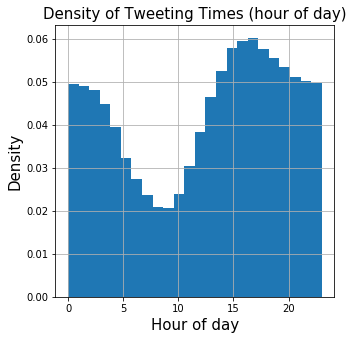

In [30]:
#FINAL EDA - times analysis visualized
plt.figure(figsize=(5,5))
plt.hist(EDA_times.Hour,bins=24,density=True,rwidth=1)
plt.title('Density of Tweeting Times (hour of day)', fontsize=15)
plt.xlabel('Hour of day', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.grid()
plt.show()

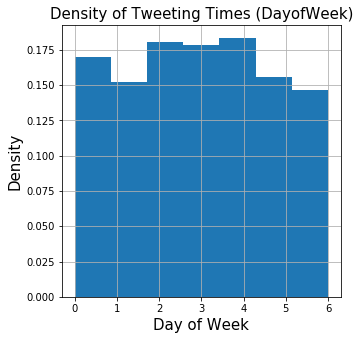

In [33]:
plt.figure(figsize=(5,5))
plt.hist(EDA_times.DayofWeek,bins=7,density=True,rwidth=1)
plt.title('Density of Tweeting Times (DayofWeek)', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.grid()
plt.show()

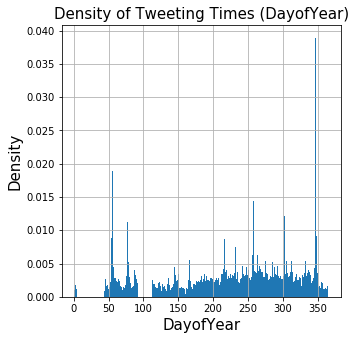

In [32]:
plt.figure(figsize=(5,5))
plt.hist(EDA_times.DayofYear,bins=365,density=True,rwidth=1)
plt.title('Density of Tweeting Times (DayofYear)', fontsize=15)
plt.xlabel('DayofYear', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.grid()
plt.show()

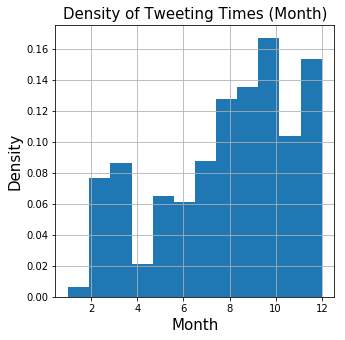

In [31]:
plt.figure(figsize=(5,5))
plt.hist(EDA_times.Month,bins=12,density=True,rwidth=1)
plt.title('Density of Tweeting Times (Month)', fontsize=15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.grid()
plt.show()

In [ ]:
#University split
#To make it easier on our local computer where we will perform analytics, we break up the filtered data into different datasets by school:

datUC = dat.filter(dat.text.rlike(\
    "UniversityofChicago|UofC|UChicago"))

datPSU = dat.filter(dat.text.rlike(\
    "PennState|PSU|PennStateUniversity"))

datRU = dat.filter(dat.text.rlike(\
    "RutgersUniversity|Rutgers|RU"))

datHU = dat.filter(dat.text.rlike(\
    "HarvardUniversity|Harvard|HU"))

In [6]:
#Even one sample of the data is too dense to visualize. We must try to simplify...
sample=dat2.first()
sample

Row(contributors=None, coordinates=None, created_at='Thu Jun 22 23:16:17 +0000 2017', display_text_range=[0, 116], entities=Row(hashtags=[Row(indices=[64, 73], text='datawise')], media=[Row(additional_media_info=None, description=None, display_url='pic.twitter.com/U0aWY5BmoS', expanded_url='https://twitter.com/diamond1911/status/878028899132686336/photo/1', id=878028871207202817, id_str='878028871207202817', indices=[117, 140], media_url='http://pbs.twimg.com/media/DC9imzrXsAErbHh.jpg', media_url_https='https://pbs.twimg.com/media/DC9imzrXsAErbHh.jpg', sizes=Row(large=Row(h=1536, resize='fit', w=2048), medium=Row(h=900, resize='fit', w=1200), small=Row(h=510, resize='fit', w=680), thumb=Row(h=150, resize='crop', w=150)), source_status_id=None, source_status_id_str=None, source_user_id=None, source_user_id_str=None, type='photo', url='https://t.co/U0aWY5BmoS')], symbols=[], urls=[], user_mentions=[Row(id=39585367, id_str='39585367', indices=[75, 83], name='Harvard University', screen_na

In [5]:
#UNIVERSITY TWEETS - FILTERING FIELDS
#We only include fields we are interested in:

datUC=datUC.select(['user','text','created_at','place','retweet_count','reply_count','favorite_count'])
datPSU=datPSU.select(['user','text','created_at','place','retweet_count','reply_count','favorite_count'])
datRU=datRU.select(['user','text','created_at','place','retweet_count','reply_count','favorite_count'])
datHU=datHU.select(['user','text','created_at','place','retweet_count','reply_count','favorite_count'])

In [3]:
#UNIVERSITY TWEETS - Save, move, load

#Save work to continue analysis locally on computer
# datUC.write.json("datUC")
# datPSU.write.json("datPSU")
# datRU.write.json("datRU")
# datHU.write.json("datHU")

#Then we use the following commands to transfer to RCC home directory, which is then transferred locally using FileZilla:
# !hdfs dfs -get datUC ~/
# !hdfs dfs -get datPSU ~/
# !hdfs dfs -get datRU ~/
# !hdfs dfs -get datHU ~/

#Load work
datUC = []

for file in os.listdir("datUC"):
    for line in open("datUC/"+file, "r", encoding="utf8"):
        datUC.append(json.loads(line))

datRU = []

for file in os.listdir("datRU"):
    for line in open("datRU/"+file, "r", encoding="utf8"):
        datRU.append(json.loads(line))
    
datPSU = []

for file in os.listdir("datPSU"):
    for line in open("datPSU/"+file, "r", encoding="utf8"):
        datPSU.append(json.loads(line))
    
datHU = []

for file in os.listdir("datHU"):
    for line in open("datHU/"+file, "r", encoding="utf8"):
        datHU.append(json.loads(line))


In [7]:
#EDA - UC TWEETS
print("Total UC tweets:",len(datUC))

UC_screennames=[]
for i in datUC:
    UC_screennames.append(i['user']['screen_name'])

print("Total UC unique tweeters: ",len(set(UC_screennames)))    
print("Average UC tweets per user:", len(UC_screennames)/len(set(UC_screennames)))

UC_followers=[]
for i in datUC:
    UC_followers.append(i['user']['followers_count'])

print("Average & Median followers per tweet:", np.mean(UC_followers),np.median(UC_followers))

UC_text=[]
for i in datUC:
    UC_text.append(len(i['text']))

print("Average tweet length: ", np.mean(UC_text))

UC_rt=[]
for i in datUC:
    UC_rt.append(i['retweet_count'])

print("Average & Median retweet count: ", np.mean(UC_rt),np.median(UC_rt))

UC_ft=[]
for i in datUC:
    UC_ft.append(i['favorite_count'])

print("Average & Median favorite count: ", np.mean(UC_ft),np.median(UC_rt))


print('\n')
print("It would seem there is no information provided by favorites, retweets, or place info")

Total UC tweets: 138840
Total UC unique tweeters:  73764
Average UC tweets per user: 1.8822189686025703
Average & Median followers per tweet: 7115.119057908384 568.0
Average tweet length:  128.92195332757132
Average & Median retweet count:  0.0 0.0
Average & Median favorite count:  0.0 0.0


It would seem there is no information provided by favorites, retweets, or place info


In [8]:
#EDA - RU TWEETS

print("Total RU tweets:",len(datRU))

RU_screennames=[]
for i in datRU:
    RU_screennames.append(i['user']['screen_name'])

print("Total RU unique tweeters: ",len(set(RU_screennames)))    
print("Average RU tweets per user:", len(RU_screennames)/len(set(RU_screennames)))

RU_followers=[]
for i in datRU:
    RU_followers.append(i['user']['followers_count'])

print("Average & Median followers per tweet:", np.mean(RU_followers),np.median(RU_followers))

RU_text=[]
for i in datRU:
    RU_text.append(len(i['text']))

print("Average tweet length: ", np.mean(RU_text))

RU_rt=[]
for i in datRU:
    RU_rt.append(i['retweet_count'])

print("Average & Median retweet count: ", np.mean(RU_rt),np.median(RU_rt))

RU_ft=[]
for i in datRU:
    RU_ft.append(i['favorite_count'])

print("Average & Median favorite count: ", np.mean(RU_ft),np.median(RU_rt))


print('\n')
print("It would seem there is no information provided by favorites, retweets, or place info")

Total RU tweets: 581042
Total RU unique tweeters:  366649
Average RU tweets per user: 1.5847363554789458
Average & Median followers per tweet: 10430.76583276252 549.0
Average tweet length:  121.68036906110058
Average & Median retweet count:  0.0 0.0
Average & Median favorite count:  0.0 0.0


It would seem there is no information provided by favorites, retweets, or place info


In [9]:
#EDA - PSU TWEETS

print("Total PSU tweets:",len(datPSU))

PSU_screennames=[]
for i in datPSU:
    PSU_screennames.append(i['user']['screen_name'])

print("Total PSU unique tweeters: ",len(set(PSU_screennames)))    
print("Average PSU tweets per user:", len(PSU_screennames)/len(set(PSU_screennames)))

PSU_followers=[]
for i in datPSU:
    PSU_followers.append(i['user']['followers_count'])

print("Average & Median followers per tweet:", np.mean(PSU_followers),np.median(PSU_followers))

PSU_text=[]
for i in datPSU:
    PSU_text.append(len(i['text']))

print("Average tweet length: ", np.mean(PSU_text))

PSU_rt=[]
for i in datPSU:
    PSU_rt.append(i['retweet_count'])

print("Average & Median retweet count: ", np.mean(PSU_rt),np.median(PSU_rt))

PSU_ft=[]
for i in datPSU:
    PSU_ft.append(i['favorite_count'])

print("Average & Median favorite count: ", np.mean(PSU_ft),np.median(PSU_rt))


print('\n')
print("It would seem there is no information provided by favorites, retweets, or place info")

Total PSU tweets: 40496
Total PSU unique tweeters:  25439
Average PSU tweets per user: 1.5918864735249028
Average & Median followers per tweet: 3961.8000543263533 407.0
Average tweet length:  126.70056301856974
Average & Median retweet count:  0.0 0.0
Average & Median favorite count:  0.0 0.0


It would seem there is no information provided by favorites, retweets, or place info


In [10]:
#EDA - HU TWEETS

print("Total HU tweets:",len(datHU))

HU_screennames=[]
for i in datHU:
    HU_screennames.append(i['user']['screen_name'])

print("Total HU unique tweeters: ",len(set(HU_screennames)))    
print("Average HU tweets per user:", len(HU_screennames)/len(set(HU_screennames)))

HU_followers=[]
for i in datHU:
    HU_followers.append(i['user']['followers_count'])

print("Average & Median followers per tweet:", np.mean(HU_followers),np.median(HU_followers))

HU_text=[]
for i in datHU:
    HU_text.append(len(i['text']))

print("Average tweet length: ", np.mean(HU_text))

HU_rt=[]
for i in datHU:
    HU_rt.append(i['retweet_count'])

print("Average & Median retweet count: ", np.mean(HU_rt),np.median(HU_rt))

HU_ft=[]
for i in datHU:
    HU_ft.append(i['favorite_count'])

print("Average & Median favorite count: ", np.mean(HU_ft),np.median(HU_rt))


print('\n')
print("It would seem there is no information provided by favorites, retweets, or place info")

Total HU tweets: 1891087
Total HU unique tweeters:  1204148
Average HU tweets per user: 1.5704772170862717
Average & Median followers per tweet: 7694.306533226658 462.0
Average tweet length:  128.11115194594433
Average & Median retweet count:  0.0 0.0
Average & Median favorite count:  0.0 0.0


It would seem there is no information provided by favorites, retweets, or place info


In [36]:
#UC PROLIFIC TWEETERS
#We will define most prolific tweeters by friends that follow them and tweeting activity.

#Step1: collect screennames for all tweets 
tweet_sns=[]
for i in datUC:
    tweet_sns.append(i['user']['screen_name'])
    
#Step2: group by screenname by count
c=Counter(tweet_sns)


#Collect list of screen names, friends, tweet count
UC_prolific_sn = []
for i in datUC:
    x=tuple((i['user']['screen_name'],i['user']['followers_count'],c[i['user']['screen_name']]))
    UC_prolific_sn.append(x)

#Reduce to unique values
dfUC=pd.DataFrame(list(set(UC_prolific_sn))) #put into dataframe
dfUC.columns=["sn","friends","tweets"] #rename columns

df1=dfUC.groupby(['sn'])['friends'].max() #find max friends 
df2=dfUC.groupby(['sn'])['tweets'].max() #find max tweets
UC_prolific=pd.concat([df1,df2],axis=1) #combine
print("Total unique UC tweeters: ",len(UC_prolific))

most_friends=UC_prolific.sort_values(by='friends',axis=0, ascending=False).iloc[0:100,:] #top 100 by friend count
most_friends.index.name = 'sn' #remake row names as its own column
most_friends.reset_index(inplace=True) #reset row numbers
most_tweets=UC_prolific.sort_values(by='tweets',axis=0, ascending=False).iloc[0:100,:] #top 100 by tweet count
most_tweets.index.name = 'sn' #remake row names as its own column
most_tweets.reset_index(inplace=True) #reset row numbers

UC_final=pd.concat([most_friends,most_tweets],axis=0).drop_duplicates() 
print("Total unique prolific tweeters (ranking in either top-100 number of friends or tweets): ",UC_final.shape[0])
UC_final.iloc[0:10]

Total unique UC tweeters:  73764
Total unique prolific tweeters (ranking in either top-100 number of friends or tweets):  200


,sn,friends,tweets
0,CNN,40779493,4
1,Forbes,13937680,2
2,HuffPost,10914184,1
3,XHNews,10648871,2
4,BillClinton,10538762,1
5,cnni,8040870,2
6,NPR,7579289,1
7,the_hindu,4412548,1
8,CoryBooker,4177454,1
9,hrw,3773612,1


In [37]:
#RU PROLIFIC TWEETERS
#We will define most prolific tweeters by friends that follow them and tweeting activity.

#Step1: collect screennames for all tweets 
tweet_sns=[]
for i in datRU:
    tweet_sns.append(i['user']['screen_name'])
    
#Step2: group by screenname by count
c=Counter(tweet_sns)


#Collect list of screen names, friends, tweet count
RU_prolific_sn = []
for i in datRU:
    x=tuple((i['user']['screen_name'],i['user']['followers_count'],c[i['user']['screen_name']]))
    RU_prolific_sn.append(x)

#Reduce to unique values
dfRU=pd.DataFrame(list(set(RU_prolific_sn))) #put into dataframe
dfRU.columns=["sn","friends","tweets"] #rename columns

df1=dfRU.groupby(['sn'])['friends'].max() #find max friends 
df2=dfRU.groupby(['sn'])['tweets'].max() #find max tweets
RU_prolific=pd.concat([df1,df2],axis=1) #combine
print("Total unique RU tweeters: ",len(RU_prolific))

most_friends=RU_prolific.sort_values(by='friends',axis=0, ascending=False).iloc[0:100,:] #top 100 by friend count
most_friends.index.name = 'sn' #remake row names as its own column
most_friends.reset_index(inplace=True) #reset row numbers
most_tweets=RU_prolific.sort_values(by='tweets',axis=0, ascending=False).iloc[0:100,:] #top 100 by tweet count
most_tweets.index.name = 'sn' #remake row names as its own column
most_tweets.reset_index(inplace=True) #reset row numbers

RU_final=pd.concat([most_friends,most_tweets],axis=0).drop_duplicates() 
print("Total unique prolific tweeters (ranking in either top-100 number of friends or tweets): ",RU_final.shape[0])
RU_final.iloc[0:10]

Total unique RU tweeters:  366649
Total unique prolific tweeters (ranking in either top-100 number of friends or tweets):  200


,sn,friends,tweets
0,NFL,24549325,1
1,BBCWorld,21941826,1
2,FoxNews,18004496,5
3,WSJ,15547161,3
4,TIME,15468792,2
5,ABC,14024308,5
6,AP,12758172,2
7,XHNews,11828739,2
8,HuffPost,11444540,1
9,timesofindia,11329614,1


In [38]:
#PSU PROLIFIC TWEETERS
#We will define most prolific tweeters by friends that follow them and tweeting activity.

#Step1: collect screennames for all tweets 
tweet_sns=[]
for i in datPSU:
    tweet_sns.append(i['user']['screen_name'])
    
#Step2: group by screenname by count
c=Counter(tweet_sns)


#Collect list of screen names, friends, tweet count
PSU_prolific_sn = []
for i in datPSU:
    x=tuple((i['user']['screen_name'],i['user']['followers_count'],c[i['user']['screen_name']]))
    PSU_prolific_sn.append(x)

#Reduce to unique values
dfPSU=pd.DataFrame(list(set(PSU_prolific_sn))) #put into dataframe
dfPSU.columns=["sn","friends","tweets"] #rename columns

df1=dfPSU.groupby(['sn'])['friends'].max() #find max friends 
df2=dfPSU.groupby(['sn'])['tweets'].max() #find max tweets
PSU_prolific=pd.concat([df1,df2],axis=1) #combine
print("Total unique PSU tweeters: ",len(PSU_prolific))

most_friends=PSU_prolific.sort_values(by='friends',axis=0, ascending=False).iloc[0:100,:] #top 100 by friend count
most_friends.index.name = 'sn' #remake row names as its own column
most_friends.reset_index(inplace=True) #reset row numbers
most_tweets=PSU_prolific.sort_values(by='tweets',axis=0, ascending=False).iloc[0:100,:] #top 100 by tweet count
most_tweets.index.name = 'sn' #remake row names as its own column
most_tweets.reset_index(inplace=True) #reset row numbers

PSU_final=pd.concat([most_friends,most_tweets],axis=0).drop_duplicates() 
print("Total unique prolific tweeters (ranking in either top-100 number of friends or tweets): ",PSU_final.shape[0])
PSU_final.iloc[0:10]

Total unique PSU tweeters:  25439
Total unique prolific tweeters (ranking in either top-100 number of friends or tweets):  197


,sn,friends,tweets
0,NFL,23861349,1
1,JayBilas,1858608,1
2,LILBTHEBASEDGOD,1501345,1
3,chicagotribune,1062706,1
4,dosomething,812077,1
5,cbfowler,798139,1
6,mohe_sa,797076,1
7,ByronErnest,682608,1
8,Pirates,671825,2
9,LALATE,537959,11


In [39]:
#HU PROLIFIC TWEETERS
#We will define most prolific tweeters by friends that follow them and tweeting activity.

#Step1: collect screennames for all tweets 
tweet_sns=[]
for i in datHU:
    tweet_sns.append(i['user']['screen_name'])
    
#Step2: group by screenname by count
c=Counter(tweet_sns)


#Collect list of screen names, friends, tweet count
HU_prolific_sn = []
for i in datHU:
    x=tuple((i['user']['screen_name'],i['user']['followers_count'],c[i['user']['screen_name']]))
    HU_prolific_sn.append(x)

#Reduce to unique values
dfHU=pd.DataFrame(list(set(HU_prolific_sn))) #put into dataframe
dfHU.columns=["sn","friends","tweets"] #rename columns

df1=dfHU.groupby(['sn'])['friends'].max() #find max friends 
df2=dfHU.groupby(['sn'])['tweets'].max() #find max tweets
HU_prolific=pd.concat([df1,df2],axis=1) #combine
print("Total unique HU tweeters: ",len(HU_prolific))

most_friends=HU_prolific.sort_values(by='friends',axis=0, ascending=False).iloc[0:100,:] #top 100 by friend count
most_friends.index.name = 'sn' #remake row names as its own column
most_friends.reset_index(inplace=True) #reset row numbers
most_tweets=HU_prolific.sort_values(by='tweets',axis=0, ascending=False).iloc[0:100,:] #top 100 by tweet count
most_tweets.index.name = 'sn' #remake row names as its own column
most_tweets.reset_index(inplace=True) #reset row numbers

HU_final=pd.concat([most_friends,most_tweets],axis=0).drop_duplicates() 
print("Total unique prolific tweeters (ranking in either top-100 number of friends or tweets): ",HU_final.shape[0])
HU_final.iloc[0:10]

Total unique HU tweeters:  1204148
Total unique prolific tweeters (ranking in either top-100 number of friends or tweets):  200


,sn,friends,tweets
0,rihanna,79390623,1
1,cnnbrk,54131251,1
2,nytimes,42429668,11
3,CNN,40853602,23
4,espn,33314359,1
5,KAKA,30292683,1
6,FCBarcelona,29204143,1
7,NBA,27414734,2
8,BBCWorld,24188942,5
9,NFL,24155246,1


In [40]:
#Consolidate list of all prolific tweeters

prolific_total=pd.concat([UC_final,RU_final,PSU_final,HU_final],axis=0).drop_duplicates()
print("Total unique prolific tweeters (before overlap adjustment): ",prolific_total.shape[0])

df1=prolific_total.groupby(['sn'])['friends'].max() #find max friends 
df2=prolific_total.groupby(['sn'])['tweets'].max() #find max tweets
prolific_total2=pd.concat([df1,df2],axis=1) #combine

prolific_total2=prolific_total2.drop_duplicates() #Drop overlapping elements after concatenation
print("Total unique prolific tweeters (after overlap adjustment): ",prolific_total2.shape[0])

prolific_total2.reset_index(inplace=True) #reset row numbers

prolific_total2.sort_values(by="tweets",axis=0,ascending=False).iloc[0:10]


Total unique prolific tweeters (before overlap adjustment):  797
Total unique prolific tweeters (after overlap adjustment):  746


,sn,friends,tweets
72,CMasden7,63,6076
31,AmericaAlerts,609,3257
212,LaughOutNOW,14447,3068
338,RUWTncaab,148,2020
590,irvin_iew2,17,1884
700,socialstocksnow,1036062,1676
603,jurnskeff,7848,1641
695,skostiaev,267,1472
457,WXHAZARDSKS,26,1435
566,harvardedits,468,1401


In [42]:
#Most prolific tweeters sorted by friends
prolific_total2.sort_values(by="friends",axis=0,ascending=False).iloc[0:10,0:2]

,sn,friends
680,rihanna,79390623
512,cnnbrk,54131251
647,nytimes,42429668
74,CNN,40853602
544,espn,33314359
199,KAKA,30292683
132,FCBarcelona,29204143
249,NBA,27414734
256,NFL,24549325
40,BBCWorld,24188942


In [43]:
#Most prolific tweeters sorted by tweets
prolific_total2.sort_values(by="tweets",axis=0,ascending=False).iloc[0:10,[0,2]]

,sn,tweets
72,CMasden7,6076
31,AmericaAlerts,3257
212,LaughOutNOW,3068
338,RUWTncaab,2020
590,irvin_iew2,1884
700,socialstocksnow,1676
603,jurnskeff,1641
695,skostiaev,1472
457,WXHAZARDSKS,1435
566,harvardedits,1401


In [8]:
#PROLIFIC TWEETERS - ALL TWEETING ACTIVITY (UNI AND NON-UNI) -  Save, move, load

#Save result
#prolific_alltweets=dat.filter(dat.user.screen_name.isin(list(prolific_total2.sn)))
#prolific_alltweets.write.json("prolific_alltweets")

#Move
#!hdfs dfs -get prolific_alltweets ~/

#Load work
prolific_alltweets = []

for file in os.listdir("prolific_alltweets"):
    for line in open("prolific_alltweets/"+file, "r", encoding="utf8"):
        prolific_alltweets.append(json.loads(line))
        

print("Total tweet count among all prolific tweeters:",len(prolific_alltweets))

#Extract screennames
prolific_alltweet_sn=[]
for i in prolific_alltweets:
    prolific_alltweet_sn.append(i['user']['screen_name'])

#Group screenname by count
c=Counter(prolific_alltweet_sn)
c


Total tweet count among all prolific tweeters: 1023964


Counter({'107kUnrivaled': 252,
         '11W': 209,
         '150Bison': 925,
         '1Iwtmmt001': 6868,
         '2Iwtmmt001': 5639,
         '2chainz': 10,
         '69News': 87,
         '7UJcwLIb28Tbg0j': 168,
         'ABC': 666,
         'ABC7Chicago': 5436,
         'ABSCBNNews': 223,
         'ACLU': 52,
         'ADAMJGON': 144,
         'AG_Hays': 530,
         'AJEnglish': 93,
         'AJ_D_23': 512,
         'ANCALERTS': 251,
         'ANI': 393,
         'ANTIGOPMVMT': 208,
         'ANTITRUMPMVMT': 518,
         'ANTlGOPMVMT': 330,
         'ANTlTRUMPMVMT': 200,
         'AP': 738,
         'ARUPBIS15310013': 295,
         'AamAadmiParty': 56,
         'AdamSchefter': 55,
         'Adriana_Lacy': 122,
         'AllenRobinson': 9,
         'AltairKaumualii': 253,
         'AmandaThienTu': 1409,
         'AmerMedicalAssn': 57,
         'AmericaAlerts': 7616,
         'AmyHermalik': 775,
         'AmyJRomine': 327,
         'AnandWrites': 25,
         'ArchDaily': 154,
  

In [12]:
#Most prolific authors (university AND non-university)
prolific_alltweets_counter=pd.DataFrame(list(c.items()))
prolific_alltweets_counter.columns = ["sn","tweets"]
prolific_alltweets_counter.head()

,sn,tweets
0,eVisitorGuide,76445
1,uchicagogsu,2279
2,CCS_Radio,70698
3,ZO2_shoes,17617
4,socialirnews,18856


In [74]:
#Q: How much are they tweeting about the Universities vs. other topics?

print("Total number of tweets from prolific users: ",np.sum(prolific_alltweets_counter.tweets))
print("University-related number of tweets from prolific users: ",np.sum(prolific_total2.tweets))
print("Multiple of non-University tweets vs. University tweets: ",np.sum(prolific_alltweets_counter.tweets)/np.sum(prolific_total2.tweets))


Total number of tweets from prolific users:  1023964
University-related number of tweets from prolific users:  104179
Multiple of non-University tweets vs. University tweets:  9.828890659345934


In [5]:
#LOCATION OF PROLIFIC AUTHORS

#Locations

UC_loc=[]
for i in datUC:
    try:
        UC_loc.append(i['user']['location'])
    except:
        pass

RU_loc=[]
for i in datRU:
    try:
        RU_loc.append(i['user']['location'])
    except:
        pass
    
PSU_loc=[]
for i in datPSU:
    try:
        PSU_loc.append(i['user']['location'])
    except:
        pass

HU_loc=[]
for i in datHU:
    try:
        HU_loc.append(i['user']['location'])
    except:
        pass

print(len(UC_loc))
print(len(RU_loc))
print(len(PSU_loc))
print(len(HU_loc))

107948
402997
28796
1320651


In [6]:
#Save for tableau visualization

# np.savetxt("UC_loc.csv", UC_loc, delimiter=",", fmt='%s')
# np.savetxt("RU_loc.csv", RU_loc, delimiter=",", fmt='%s')
# np.savetxt("PSU_loc.csv", PSU_loc, delimiter=",", fmt='%s')
# np.savetxt("HU_loc.csv", HU_loc, delimiter=",", fmt='%s')


In [ ]:
#DISTINGUISHING UC vs. Rest of Authors

In [30]:
#DISTINGUISHING AUTHORS 
#Collect university prolific author tweets
UC_protweets=dat.filter(dat.user.screen_name.isin(list(UC_final.sn)))
RU_protweets=dat.filter(dat.user.screen_name.isin(list(RU_final.sn)))
PSU_protweets=dat.filter(dat.user.screen_name.isin(list(PSU_final.sn)))
HU_protweets=dat.filter(dat.user.screen_name.isin(list(HU_final.sn)))

print("UC prolific tweets count: ",UC_protweets.count())
print("RU prolific tweets count: ",RU_protweets.count())
print("PSU prolific tweets count: ",PSU_protweets.count())
print("HU prolific tweets count: ",HU_protweets.count())

UC prolific tweets count:  118932
RU prolific tweets count:  629810
PSU prolific tweets count:  157069
HU prolific tweets count:  307670


In [33]:
#DISTINGUISHING AUTHORS
#Save
# UC_protweets.write.json("UC_protweets")
# RU_protweets.write.json("RU_protweets")
# PSU_protweets.write.json("PSU_protweets")
# HU_protweets.write.json("HU_protweets")

In [34]:
#DISTINGUISHING AUTHORS
#Move
# !hdfs dfs -get UC_protweets ~/
# !hdfs dfs -get RU_protweets ~/
# !hdfs dfs -get PSU_protweets ~/
# !hdfs dfs -get HU_protweets ~/

Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0
Java HotSpot(TM) 64-Bit Server VM warning: ignoring option MaxPermSize=512M; support was removed in 8.0


In [45]:
#DISTINGUISHING AUTHORS
#Load

UC_protweets = []
for file in os.listdir("UC_protweets"):
    for line in open("UC_protweets/"+file, "r", encoding="utf8"):
        UC_protweets.append(json.loads(line))
        
RU_protweets = []
for file in os.listdir("RU_protweets"):
    for line in open("RU_protweets/"+file, "r", encoding="utf8"):
        RU_protweets.append(json.loads(line))
        
PSU_protweets = []
for file in os.listdir("PSU_protweets"):
    for line in open("PSU_protweets/"+file, "r", encoding="utf8"):
        PSU_protweets.append(json.loads(line))
        
HU_protweets = []
for file in os.listdir("HU_protweets"):
    for line in open("HU_protweets/"+file, "r", encoding="utf8"):
        HU_protweets.append(json.loads(line))

In [37]:
print("Sanity check on UC protweet count:" ,len(UC_protweets))
print("Sanity check on RU protweet count:" ,len(RU_protweets))
print("Sanity check on PSU protweet count:" ,len(PSU_protweets))
print("Sanity check on HU protweet count:" ,len(HU_protweets))

Sanity check on UC protweet count: 118932
Sanity check on RU protweet count: 629810
Sanity check on PSU protweet count: 157069
Sanity check on HU protweet count: 307670


In [46]:
#DISTINGUISHING AUTHORS - collecting characteristics 

UCfriendscount=[]
for i in UC_protweets:
    try:
        UCfriendscount.append(i['user']['friends_count'])
    except:
        pass
    
UCfollowerscount=[]
for i in UC_protweets:
    try:
        UCfollowerscount.append(i['user']['followers_count'])
    except:
        pass 
    
UCfavcount=[]
for i in UC_protweets:
    try:
        UCfavcount.append(i['user']['favourites_count'])
    except:
        pass 
    
UCstatusescount=[]
for i in UC_protweets:
    try:
        UCstatusescount.append(i['user']['statuses_count'])
    except:
        pass 
    
UCdefaultprofile=[]
for i in UC_protweets:
    try:
        UCdefaultprofile.append(i['user']['default_profile'])
    except:
        pass 
    
UCtextlength=[]
for i in UC_protweets:
    try:
        UCtextlength.append(len(i['text']))
    except:
        pass 
    
    
#---------------------

RUfriendscount=[]
for i in RU_protweets:
    try:
        RUfriendscount.append(i['user']['friends_count'])
    except:
        pass
    
RUfollowerscount=[]
for i in RU_protweets:
    try:
        RUfollowerscount.append(i['user']['followers_count'])
    except:
        pass 
    
RUfavcount=[]
for i in RU_protweets:
    try:
        RUfavcount.append(i['user']['favourites_count'])
    except:
        pass 
    
RUstatusescount=[]
for i in RU_protweets:
    try:
        RUstatusescount.append(i['user']['statuses_count'])
    except:
        pass 
    
RUdefaultprofile=[]
for i in RU_protweets:
    try:
        RUdefaultprofile.append(i['user']['default_profile'])
    except:
        pass 
    
RUtextlength=[]
for i in RU_protweets:
    try:
        RUtextlength.append(len(i['text']))
    except:
        pass 
    

#---------------------
PSUfriendscount=[]
for i in PSU_protweets:
    try:
        PSUfriendscount.append(i['user']['friends_count'])
    except:
        pass
    
PSUfollowerscount=[]
for i in PSU_protweets:
    try:
        PSUfollowerscount.append(i['user']['followers_count'])
    except:
        pass 
    
PSUfavcount=[]
for i in PSU_protweets:
    try:
        PSUfavcount.append(i['user']['favourites_count'])
    except:
        pass 
    
PSUstatusescount=[]
for i in PSU_protweets:
    try:
        PSUstatusescount.append(i['user']['statuses_count'])
    except:
        pass 

PSUdefaultprofile=[]
for i in PSU_protweets:
    try:
        PSUdefaultprofile.append(i['user']['default_profile'])
    except:
        pass 
    
PSUtextlength=[]
for i in PSU_protweets:
    try:
        PSUtextlength.append(len(i['text']))
    except:
        pass 
    
    
#---------------------
HUfriendscount=[]
for i in HU_protweets:
    try:
        HUfriendscount.append(i['user']['friends_count'])
    except:
        pass
    
HUfollowerscount=[]
for i in HU_protweets:
    try:
        HUfollowerscount.append(i['user']['followers_count'])
    except:
        pass 
    
HUfavcount=[]
for i in HU_protweets:
    try:
        HUfavcount.append(i['user']['favourites_count'])
    except:
        pass 
    
HUstatusescount=[]
for i in HU_protweets:
    try:
        HUstatusescount.append(i['user']['statuses_count'])
    except:
        pass 

HUdefaultprofile=[]
for i in HU_protweets:
    try:
        HUdefaultprofile.append(i['user']['default_profile'])
    except:
        pass 
    
HUtextlength=[]
for i in HU_protweets:
    try:
        HUtextlength.append(len(i['text']))
    except:
        pass 
    


In [47]:
#DISTINGUISHING AUTHORS - averaging characteristics, pooling all non-UC together

UCfriendscount_mean=np.mean(UCfriendscount)
UCfollowerscount_mean=np.mean(UCfollowerscount)
UCfavcount_mean=np.mean(UCfavcount)
UCstatusescount_mean=np.mean(UCstatusescount)
UCtextlength_mean=np.mean(UCtextlength)

OtherUni_friendscount_mean=np.mean(PSUfriendscount+RUfriendscount+HUfriendscount)
OtherUni_followerscount_mean=np.mean(PSUfollowerscount+RUfollowerscount+HUfollowerscount)
OtherUni_favcount_mean=np.mean(PSUfavcount+RUfavcount+HUfavcount)
OtherUni_statusescount_mean=np.mean(PSUstatusescount+RUstatusescount+HUstatusescount)
OtherUni_textlength_mean=np.mean(PSUtextlength+RUtextlength+HUtextlength)

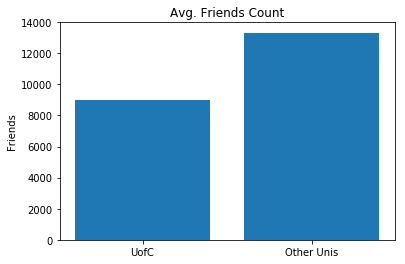

In [19]:
#DISTINGUISHING AUTHORS - Avg. Friends Count
plt.bar(["UofC","Other Unis"], [UCfriendscount_mean,OtherUni_friendscount_mean])
plt.ylabel('Friends')
plt.title('Avg. Friends Count')
plt.show()

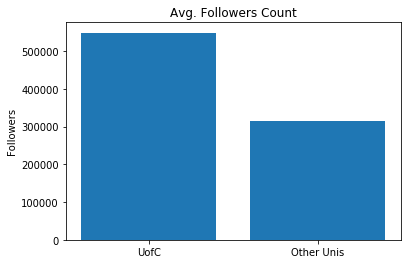

In [20]:
#DISTINGUISHING AUTHORS - Avg. Followers Count
plt.bar(["UofC","Other Unis"], [UCfollowerscount_mean,OtherUni_followerscount_mean])
plt.ylabel('Followers')
plt.title('Avg. Followers Count')
plt.show()

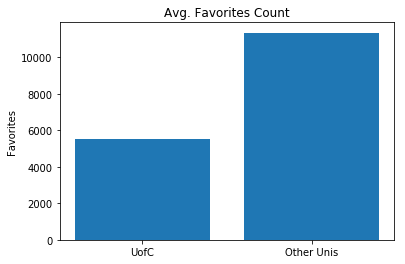

In [21]:
#DISTINGUISHING AUTHORS - Avg. Favorites Count
plt.bar(["UofC","Other Unis"], [UCfavcount_mean,OtherUni_favcount_mean])
plt.ylabel('Favorites')
plt.title('Avg. Favorites Count')
plt.show()

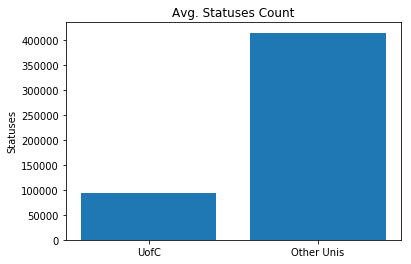

In [22]:
#DISTINGUISHING AUTHORS - Avg. Statuses Count
plt.bar(["UofC","Other Unis"], [UCstatusescount_mean,OtherUni_statusescount_mean])
plt.ylabel('Statuses')
plt.title('Avg. Statuses Count')
plt.show()

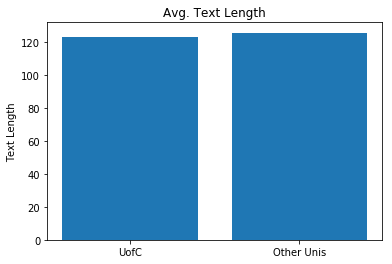

In [23]:
#DISTINGUISHING AUTHORS - Avg. Text Length
plt.bar(["UofC","Other Unis"], [UCtextlength_mean,OtherUni_textlength_mean])
plt.ylabel('Text Length')
plt.title('Avg. Text Length')
plt.show()

In [ ]:
#TIMELINES OF UNIVERSITY TWEETS

UC_times=[] #initialize list of times
for i in datUC:
    UC_times.append(i['created_at']) #fill list with times
UC_times=pd.DataFrame(UC_times) #dataframe it
UC_times.columns=["created_at"] #column name
UC_times=pd.to_datetime(UC_times['created_at']) #convert to timestamp
print("UC data collection gaps for times?")
print("UofC tweet count: ",len(datUC))
print("Timestamp collection count: ",UC_times.shape[0])
print("\n")

UC_hr=[] #Parse timestamp into components for analysis and visualization
for i in UC_times:
    UC_hr.append(i.hour)

UC_dow=[]
for i in UC_times:
    UC_dow.append(i.dayofweek)

UC_doy=[]
for i in UC_times:
    UC_doy.append(i.dayofyear)

UC_m=[]
for i in UC_times:
    UC_m.append(i.month)

UC_times=pd.concat([pd.DataFrame(UC_hr),pd.DataFrame(UC_dow),pd.DataFrame(UC_doy),pd.DataFrame(UC_m)],axis=1)
UC_times.columns=["Hour","DayofWeek","DayofYear","Month"]

    
RU_times=[]
for i in datRU:
    RU_times.append(i['created_at'])
RU_times=pd.DataFrame(RU_times)
RU_times.columns=["created_at"]
RU_times=pd.to_datetime(RU_times['created_at'])
print("RU data collection gaps for times?")
print("RU tweet count: ",len(datRU))
print("Timestamp collection count: ",RU_times.shape[0])
print("\n")

RU_hr=[]
for i in RU_times:
    RU_hr.append(i.hour)

RU_dow=[]
for i in RU_times:
    RU_dow.append(i.dayofweek)

RU_doy=[]
for i in RU_times:
    RU_doy.append(i.dayofyear)

RU_m=[]
for i in RU_times:
    RU_m.append(i.month)

RU_times=pd.concat([pd.DataFrame(RU_hr),pd.DataFrame(RU_dow),pd.DataFrame(RU_doy),pd.DataFrame(RU_m)],axis=1)
RU_times.columns=["Hour","DayofWeek","DayofYear","Month"]

    
PSU_times=[]
for i in datPSU:
    PSU_times.append(i['created_at'])
PSU_times=pd.DataFrame(PSU_times)
PSU_times.columns=["created_at"] 
PSU_times=pd.to_datetime(PSU_times['created_at'])
print("PSU data collection gaps for times?")
print("PSU tweet count: ",len(datPSU))
print("Timestamp collection count: ",PSU_times.shape[0])
print("\n")

PSU_hr=[]
for i in PSU_times:
    PSU_hr.append(i.hour)

PSU_dow=[]
for i in PSU_times:
    PSU_dow.append(i.dayofweek)

PSU_doy=[]
for i in PSU_times:
    PSU_doy.append(i.dayofyear)

PSU_m=[]
for i in PSU_times:
    PSU_m.append(i.month)

PSU_times=pd.concat([pd.DataFrame(PSU_hr),pd.DataFrame(PSU_dow),pd.DataFrame(PSU_doy),pd.DataFrame(PSU_m)],axis=1)
PSU_times.columns=["Hour","DayofWeek","DayofYear","Month"]

HU_times=[]
for i in datHU:
    HU_times.append(i['created_at'])
HU_times=pd.DataFrame(HU_times)
HU_times.columns=["created_at"]
HU_times=pd.to_datetime(HU_times['created_at'])
print("HU data collection gaps for times?")
print("HU tweet count: ",len(datHU))
print("Timestamp collection count: ",HU_times.shape[0])
print("\n")

HU_hr=[]
for i in HU_times:
    HU_hr.append(i.hour)

HU_dow=[]
for i in HU_times:
    HU_dow.append(i.dayofweek)

HU_doy=[]
for i in HU_times:
    HU_doy.append(i.dayofyear)

HU_m=[]
for i in HU_times:
    HU_m.append(i.month)

HU_times=pd.concat([pd.DataFrame(HU_hr),pd.DataFrame(HU_dow),pd.DataFrame(HU_doy),pd.DataFrame(HU_m)],axis=1)
HU_times.columns=["Hour","DayofWeek","DayofYear","Month"]



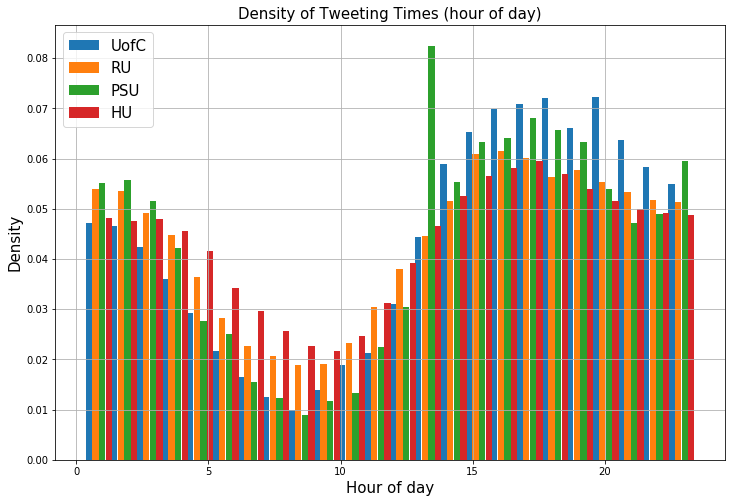

Users in general post most between 3pm-8pm local time, and least between 6am-11am


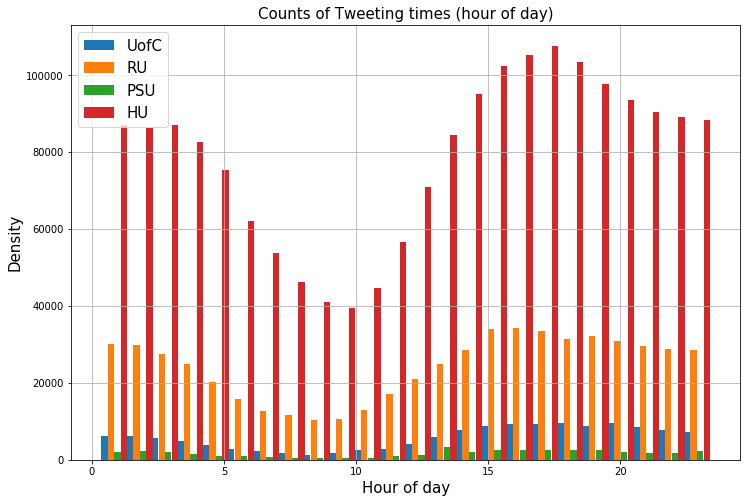

Harvard has by far the most activity for each hour, followed by Rutgers, UChicago, and Penn State


In [50]:
plt.figure(figsize=(12,8))
plt.hist(UC_times.Hour,bins=24,density=True,rwidth=.25)
plt.hist(RU_times.Hour+.25,bins=24,density=True,rwidth=.25)
plt.hist(PSU_times.Hour+.5,bins=24,density=True,rwidth=.25)
plt.hist(HU_times.Hour+.75,bins=24,density=True,rwidth=.25)
plt.title('Density of Tweeting Times (hour of day)', fontsize=15)
plt.xlabel('Hour of day', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()

print("Users in general post most between 3pm-8pm local time, and least between 6am-11am")

plt.figure(figsize=(12,8))
plt.hist(UC_times.Hour,bins=24,rwidth=.25)
plt.hist(RU_times.Hour+.25,bins=24,rwidth=.25)
plt.hist(PSU_times.Hour+.5,bins=24,rwidth=.25)
plt.hist(HU_times.Hour+.75,bins=24,rwidth=.25)
plt.title('Counts of Tweeting times (hour of day)', fontsize=15)
plt.xlabel('Hour of day', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()



print("Harvard has by far the most activity for each hour, followed by Rutgers, UChicago, and Penn State")

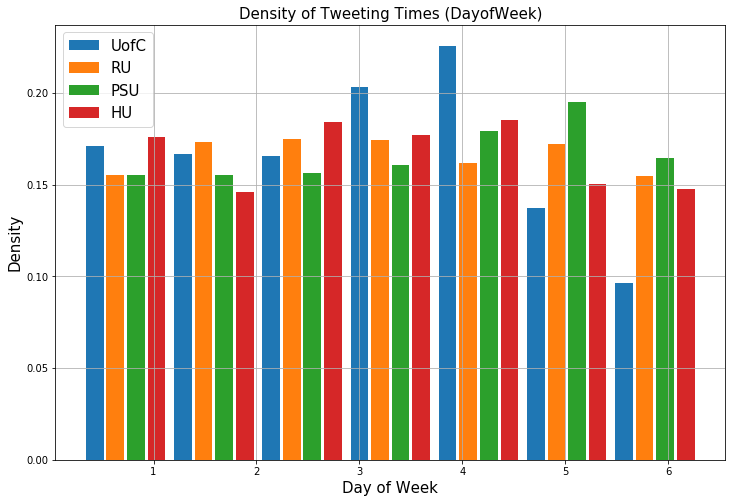

Density shows some slight differences, with UChicago showing high activity mid-week and low end-week.
RU and PSU are similar, but with RU slightly more concentrated before end of week
HU shows a in-between trend among all schools, with gradually increasing activity before felling off end of week.


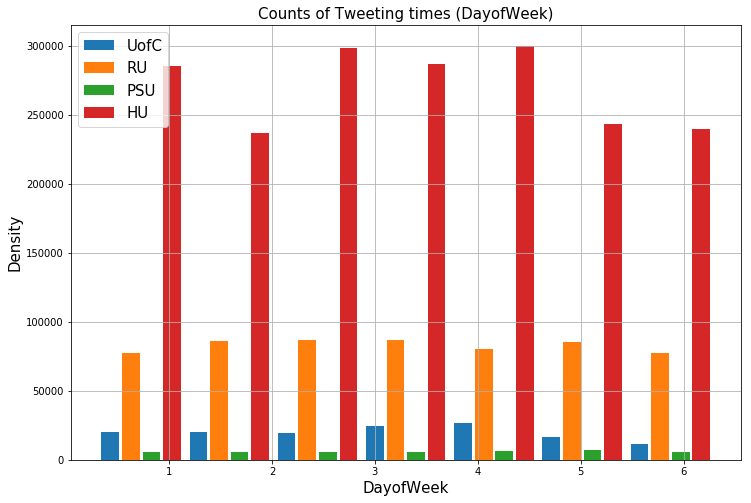

In [63]:
plt.figure(figsize=(12,8))
plt.hist(UC_times.DayofWeek,bins=7,density=True,rwidth=.2)
plt.hist(RU_times.DayofWeek+.2,bins=7,density=True,rwidth=.2)
plt.hist(PSU_times.DayofWeek+.4,bins=7,density=True,rwidth=.2)
plt.hist(HU_times.DayofWeek+.6,bins=7,density=True,rwidth=.2)
plt.title('Density of Tweeting Times (DayofWeek)', fontsize=15)
plt.xlabel('Day of Week', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()

print("Density shows some slight differences, with UChicago showing high activity mid-week and low end-week.")
print("RU and PSU are similar, but with RU slightly more concentrated before end of week")
print("HU shows a in-between trend among all schools, with gradually increasing activity before felling off end of week.")

plt.figure(figsize=(12,8))
plt.hist(UC_times.DayofWeek,bins=7,rwidth=.2)
plt.hist(RU_times.DayofWeek+.2,bins=7,rwidth=.2)
plt.hist(PSU_times.DayofWeek+.4,bins=7,rwidth=.2)
plt.hist(HU_times.DayofWeek+.6,bins=7,rwidth=.2)
plt.title('Counts of Tweeting times (DayofWeek)', fontsize=15)
plt.xlabel('DayofWeek', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()



print("Absolute levels show the same as before: Harvard dominating, followed by Rutgers, UChicago, and Penn State")

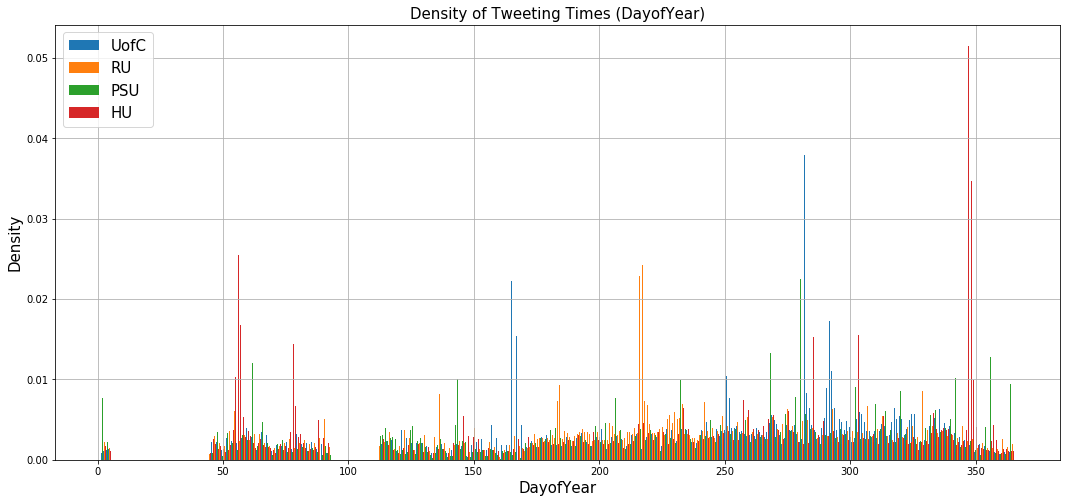

Day of year reveals some time gaps with no activity throughout the first third of the year.
Additionally, all schools show bursts of extreme outliers


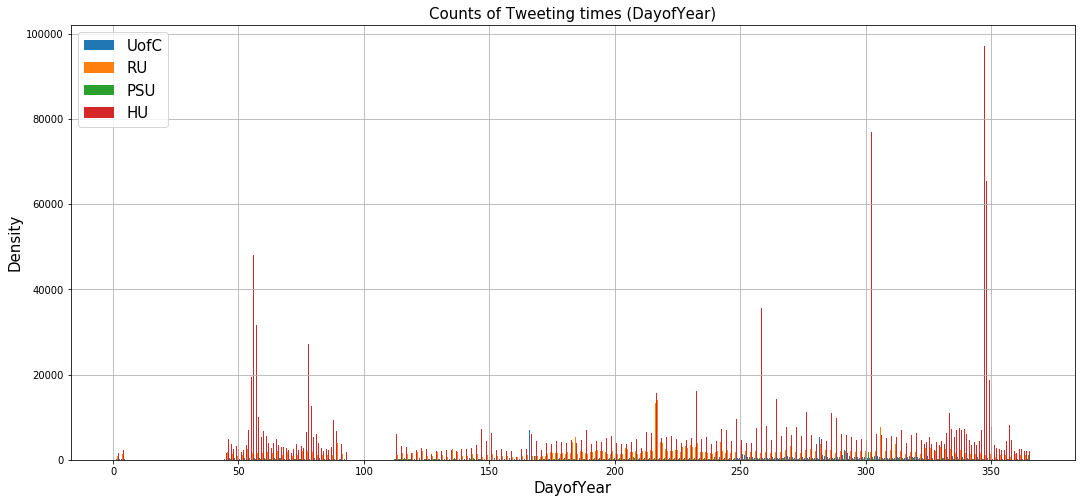

Some differences in absolute levels showing that Harvard's previously shown volume was relatively more concentrated to a few days compared to the rest of the schools, and reveals Rutgers to be more even than previously thought. UChicago and Penn State remain in 3rd and 4th place respectively.


In [73]:
plt.figure(figsize=(18,8))
plt.hist(UC_times.DayofYear,bins=365,density=True,rwidth=.25)
plt.hist(RU_times.DayofYear+.25,bins=365,density=True,rwidth=.25)
plt.hist(PSU_times.DayofYear+.5,bins=365,density=True,rwidth=.25)
plt.hist(HU_times.DayofYear+.75,bins=365,density=True,rwidth=.25)
plt.title('Density of Tweeting Times (DayofYear)', fontsize=15)
plt.xlabel('DayofYear', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()

print("Day of year reveals some time gaps with no activity throughout the first third of the year.")
print("Additionally, all schools show bursts of extreme outliers")
      
      
plt.figure(figsize=(18,8))
plt.hist(UC_times.DayofYear,bins=365,rwidth=.25)
plt.hist(RU_times.DayofYear+.25,bins=365,rwidth=.25)
plt.hist(PSU_times.DayofYear+.5,bins=365,rwidth=.25)
plt.hist(HU_times.DayofYear+.75,bins=365,rwidth=.25)
plt.title('Counts of Tweeting times (DayofYear)', fontsize=15)
plt.xlabel('DayofYear', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()



print("Some differences in absolute levels showing that Harvard's previously shown volume was relatively more concentrated to a few days compared to the rest of the schools, and reveals Rutgers to be more even than previously thought. UChicago and Penn State remain in 3rd and 4th place respectively.")

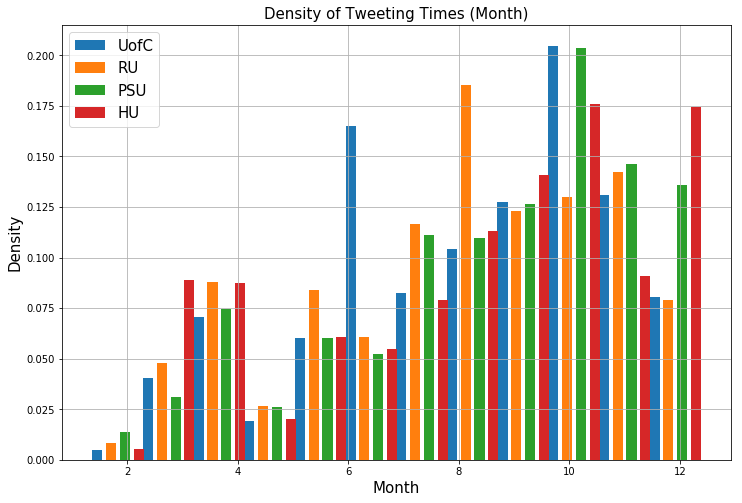

Month of Year analysis shows UChicago clearly outstanding in terms of its concentration in a few months (i.e. June and October).
PSU also shows relative concentration near the end of the year, HU at the polar ends of the year, and RU is the most evenly spread.


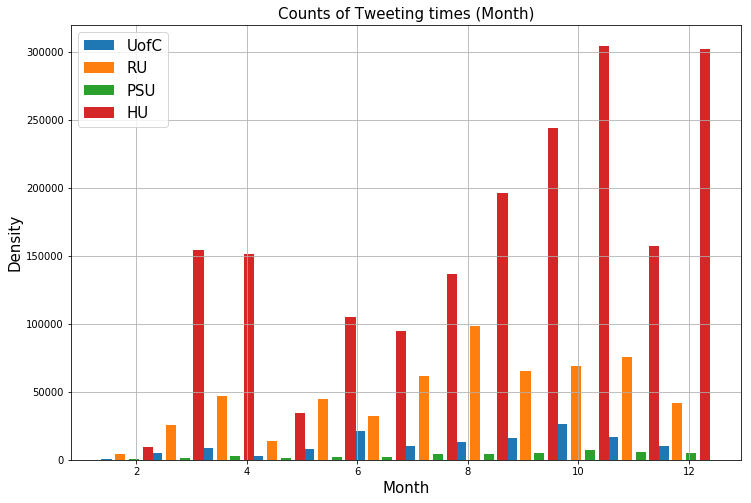

The absolute levels are similar to the rankings found on hour and days of week.


In [72]:
plt.figure(figsize=(12,8))
plt.hist(UC_times.Month,bins=12,density=True,rwidth=.2)
plt.hist(RU_times.Month+.25,bins=12,density=True,rwidth=.2)
plt.hist(PSU_times.Month+.5,bins=12,density=True,rwidth=.2)
plt.hist(HU_times.Month+.75,bins=12,density=True,rwidth=.2)
plt.title('Density of Tweeting Times (Month)', fontsize=15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()

print("Month of Year analysis shows UChicago clearly outstanding in terms of its concentration in a few months (i.e. June and October).")
print("PSU also shows relative concentration near the end of the year, HU at the polar ends of the year, and RU is the most evenly spread.")

plt.figure(figsize=(12,8))
plt.hist(UC_times.Month,bins=12,rwidth=.2)
plt.hist(RU_times.Month+.25,bins=12,rwidth=.2)
plt.hist(PSU_times.Month+.5,bins=12,rwidth=.2)
plt.hist(HU_times.Month+.75,bins=12,rwidth=.2)
plt.title('Counts of Tweeting times (Month)', fontsize=15)
plt.xlabel('Month', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.legend(labels=("UofC","RU","PSU","HU"),loc='upper left', fontsize=15)
plt.grid()
plt.show()



print("The absolute levels are similar to the rankings found on hour and days of week.")

In [ ]:
print("UofC top 5 authors: ",UC_final) 
print("RU top 5 authors: ",RU_final) 
print("PSU top 5 authors: ",PSU_final) 
print("HU top 5 authors: ",HU_final) 

In [86]:
UC_final.head()

,sn,friends,tweets
0,CNN,40779493,4
1,Forbes,13937680,2
2,HuffPost,10914184,1
3,XHNews,10648871,2
4,BillClinton,10538762,1


In [42]:
#TEXT ANALYSIS w/Simhash + Jaccard

#Define needed functions. 
def get_features(s):
  width = 3
  s = s.lower()
  s = re.sub(r'[^\w]+', '', s)
  return [s[i:i + width] for i in range(max(len(s) - width + 1, 1))]


def jaccard(text1, text2,n):

    doc1 = list(nltk.ngrams(text1.split(),n=n))
    doc2 = list(nltk.ngrams(text2.split(),n=n))

    intersection = len(list(set(doc1).intersection(set(doc2))))
    union = len(set(doc1)) + len(set(doc2)) - intersection
    jaccard_similarity = intersection / union
    
    return jaccard_similarity


#Extract title data to dataframe
text_UC=[]
for i in datUC:
    text_UC.append(i['text'])
    
text_UC=pd.DataFrame(text_UC)
print("Number of UC texts:", len(text_UC))

randomindex=np.random.randint(1,len(text_UC),size=10000)
text_UC=text_UC.loc[randomindex,:]
print("Random samples drawn :", len(text_UC))

print(text_UC.head()) #Extract titles from data
print("\n")

text_RU=[]
for i in datRU:
    text_RU.append(i['text'])
    
text_RU=pd.DataFrame(text_RU)
print("Number of RU texts:", len(text_RU))

randomindex=np.random.randint(1,len(text_RU),size=10000)
text_RU=text_RU.loc[randomindex,:]
print("Random samples drawn :", len(text_RU))

print(text_UC.head()) #Extract titles from data
print("\n")

text_PSU=[]
for i in datPSU:
    text_PSU.append(i['text'])
    
text_PSU=pd.DataFrame(text_PSU)
print("Number of PSU texts:", len(text_PSU))

randomindex=np.random.randint(1,len(text_PSU),size=10000)
text_PSU=text_PSU.loc[randomindex,:]
print("Random samples drawn :", len(text_PSU))

print(text_PSU.head()) #Extract titles from data
print("\n")

text_HU=[]
for i in datHU:
    text_HU.append(i['text'])
    
text_HU=pd.DataFrame(text_HU)
print("Number of HU texts:", len(text_HU))

randomindex=np.random.randint(1,len(text_HU),size=10000)
text_HU=text_HU.loc[randomindex,:]
print("Random samples drawn :", len(text_HU))

print(text_HU.head()) #Extract titles from data
print("\n")




Number of UC texts: 138840
Random samples drawn : 10000
                                                        0
110161  UChicago Impact | How to Interpret Response Ra...
118707  RT @Agrilinks: Don't miss tomorrow's book laun...
69665   RT @deblnia: Cults at UChicago:\n- Admissions ...
97131   3 bed. main floor of a house in Brentwood bung...
99980   UChicago scientists create alternate evolution...


Number of RU texts: 581042
Random samples drawn : 10000
                                                        0
110161  UChicago Impact | How to Interpret Response Ra...
118707  RT @Agrilinks: Don't miss tomorrow's book laun...
69665   RT @deblnia: Cults at UChicago:\n- Admissions ...
97131   3 bed. main floor of a house in Brentwood bung...
99980   UChicago scientists create alternate evolution...


Number of PSU texts: 40496
Random samples drawn : 10000
                                                       0
667    RT @BMB_PSU: Public invited to Tenth Annual Po...
23169  Rachel Weis

In [43]:
#Convert into Simhash
UC_titles_dict = text_UC.iloc[:,0].to_dict() #Create dictionary of titles
UC_titles_sim = [(str(k), Simhash(get_features(v))) for k, v in UC_titles_dict.items()] #Transform text into Simhash format
print("UC simhash titles: ")
print(UC_titles_sim[0:5])
print("\n")

RU_titles_dict = text_RU.iloc[:,0].to_dict() #Create dictionary of titles
RU_titles_sim = [(str(k), Simhash(get_features(v))) for k, v in RU_titles_dict.items()] #Transform text into Simhash format
print("RU simhash titles: ")
print(RU_titles_sim[0:5])
print("\n")

PSU_titles_dict = text_PSU.iloc[:,0].to_dict() #Create dictionary of titles
PSU_titles_sim = [(str(k), Simhash(get_features(v))) for k, v in PSU_titles_dict.items()] #Transform text into Simhash format
print("PSU simhash titles: ")
print(PSU_titles_sim[0:5])
print("\n")

HU_titles_dict = text_HU.iloc[:,0].to_dict() #Create dictionary of titles
HU_titles_sim = [(str(k), Simhash(get_features(v))) for k, v in HU_titles_dict.items()] #Transform text into Simhash format
print("UC simhash titles: ")
print(HU_titles_sim[0:5])
print("\n")


print("Length of UC text & simhash conversions: ",len(text_UC),len(UC_titles_sim))
print("Length of RU text & simhash conversions: ",len(text_RU),len(RU_titles_sim))
print("Length of PSU text & simhash conversions: ",len(text_PSU),len(PSU_titles_sim))
print("Length of HU text & simhash conversions: ",len(text_HU),len(HU_titles_sim))
print("\n")

UC simhash titles: 
[('110161', <simhash.Simhash object at 0x7f28d9d8cf60>), ('118707', <simhash.Simhash object at 0x7f294630ab38>), ('69665', <simhash.Simhash object at 0x7f294630aa58>), ('97131', <simhash.Simhash object at 0x7f294630a208>), ('99980', <simhash.Simhash object at 0x7f294630a630>)]


RU simhash titles: 
[('143827', <simhash.Simhash object at 0x7f2949f996a0>), ('420037', <simhash.Simhash object at 0x7f294630c240>), ('318601', <simhash.Simhash object at 0x7f2949f992b0>), ('117682', <simhash.Simhash object at 0x7f2946311518>), ('490110', <simhash.Simhash object at 0x7f2949f99c50>)]


PSU simhash titles: 
[('667', <simhash.Simhash object at 0x7f2949f6b518>), ('23169', <simhash.Simhash object at 0x7f2949f6bd68>), ('12387', <simhash.Simhash object at 0x7f2949f6b240>), ('28620', <simhash.Simhash object at 0x7f2949f6b780>), ('26954', <simhash.Simhash object at 0x7f2949f6be48>)]


UC simhash titles: 
[('257872', <simhash.Simhash object at 0x7f2949c060b8>), ('504555', <simhash.Sim

In [123]:
#Run similarity and put into buckets using simhash with k=3 tolerance. A lower tolerance is better for shorter documents.
print("We apply a k=3 tolerance for Simhash")
UC_index = SimhashIndex(UC_titles_sim, k=3)

#Scan buckets and make a list of lists of Simhash INDEX values to find original title:
UC_similarity_list=[]
for i in text_UC.loc[:,0]:
    UC_similarity_list.append(UC_index.get_near_dups(Simhash(get_features(i))))
    
#Removing duplicates
UC_text_indexes = []
for x in UC_similarity_list:
    if x not in UC_text_indexes:
      UC_text_indexes.append(x)
    
#----------------------------
RU_index = SimhashIndex(RU_titles_sim, k=3)

#Scan buckets and make a list of lists of Simhash INDEX values to find original title:
RU_similarity_list=[]
for i in text_RU.loc[:,0]:
    RU_similarity_list.append(RU_index.get_near_dups(Simhash(get_features(i))))
    
#Removing duplicates
RU_text_indexes = []
for x in RU_similarity_list:
    if x not in RU_text_indexes:
      RU_text_indexes.append(x)
    
#----------------------------   
PSU_index = SimhashIndex(PSU_titles_sim, k=3)

#Scan buckets and make a list of lists of Simhash INDEX values to find original title:
PSU_similarity_list=[]
for i in text_PSU.loc[:,0]:
    PSU_similarity_list.append(PSU_index.get_near_dups(Simhash(get_features(i))))
    
#Removing duplicates
PSU_text_indexes = []
for x in PSU_similarity_list:
    if x not in PSU_text_indexes:
      PSU_text_indexes.append(x)
    
#----------------------------   
HU_index = SimhashIndex(HU_titles_sim, k=3)

#Scan buckets and make a list of lists of Simhash INDEX values to find original title:
HU_similarity_list=[]
for i in text_HU.loc[:,0]:
    HU_similarity_list.append(HU_index.get_near_dups(Simhash(get_features(i))))
    
#Removing duplicates
HU_text_indexes = []
for x in HU_similarity_list:
    if x not in HU_text_indexes:
      HU_text_indexes.append(x)


We apply a k=3 tolerance for Simhash


Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket f

Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket f

Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket f

Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket f

Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket f

Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket f

Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:c57f:0, len:267
Big bucket found. key:e1ef:1, len:267
Big bucket found. key:f1a0:2, len:268
Big bucket found. key:4a20:3, len:267
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket found. key:494c:1, len:771
Big bucket found. key:cd33:2, len:771
Big bucket found. key:f834:3, len:771
Big bucket found. key:97a9:0, len:771
Big bucket f

Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. 

Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. k

Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. 

Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. k

Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. 

Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. k

Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. k

Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. key:82c:2, len:424
Big bucket found. key:e957:3, len:423
Big bucket found. key:2c91:0, len:423
Big bucket found. key:7372:1, len:423
Big bucket found. 

Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found.

Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found

Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket foun

Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found.

Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket foun

Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket foun

Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found.

Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket fou

Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found

Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket foun

Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket fou

Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket found. key:d4b:2, len:319
Big bucket found. key:1324:3, len:319
Big bucket found. key:4e4b:0, len:254
Big bucket found. key:73ac:1, len:255
Big bucket found. key:34ec:2, len:254
Big bucket found. key:fcca:3, len:254
Big bucket found. key:148a:0, len:318
Big bucket found. key:1086:1, len:319
Big bucket fou

Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket foun

Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket fou

Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:f78:2, len:255
Big bucket found. key:25c1:0, len:208
Big bucket foun

Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket foun

Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket foun

Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket fou

Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found

Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket fou

Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:f78:2, len:255
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket foun

Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket f

Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:f78:2, len:255
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket foun

Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket foun

Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket fou

Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. 

Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket fou

Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:f78:2, len:255
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found

Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found

Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:f78:2, len:255
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket foun

Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:f78:2, len:255
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket fou

Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket fou

Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket f

Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found

Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket fou

Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket foun

Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bbde:1, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket fou

Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket foun

Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:f78:2, len:255
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket fo

Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket foun

Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found

Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket fou

Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket foun

Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:bbde:1, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:f78:2, len:255
Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket foun

Big bucket found. key:25c1:0, len:208
Big bucket found. key:bbde:1, len:218
Big bucket found. key:f78:2, len:255
Big bucket found. key:aa40:3, len:218
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:e501:0, len:245
Big bucket found. key:baee:1, len:244
Big bucket fou

Big bucket found. key:2778:2, len:244
Big bucket found. key:aa44:3, len:246
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket fou

Big bucket found. key:aa40:3, len:218
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:f78:2, len:255
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. key:6bd3:0, len:878
Big bucket found. key:1561:1, len:876
Big bucket found. key:661d:2, len:876
Big bucket found. key:1426:3, len:876
Big bucket found. key:bd0b:0, len:568
Big bucket found. key:ec8c:1, len:567
Big bucket found. key:ebc:2, len:567
Big bucket found. key:701e:3, len:567
Big bucket found. 

In [127]:
#Example of output
print("UC text index similarity list output: ")
UC_text_indexes[0:10]

UC text index similarity list output: 


[['110161'],
 ['118707', '118689'],
 ['118296', '69665'],
 ['97131'],
 ['99980'],
 ['96533',
  '73497',
  '70899',
  '133202',
  '20107',
  '106528',
  '96612',
  '11908',
  '65771',
  '29450',
  '126651',
  '67275',
  '17424',
  '96684',
  '131362',
  '65769',
  '96666',
  '68120',
  '6385',
  '108672',
  '72838',
  '109133',
  '6328',
  '103234',
  '33966',
  '55',
  '34925',
  '85724',
  '27823',
  '29266',
  '109035',
  '67324',
  '136939',
  '12885',
  '126571',
  '103446',
  '113232',
  '113198',
  '96245',
  '103295',
  '108530',
  '34853',
  '29366',
  '21732',
  '21795',
  '6441',
  '125834',
  '27887',
  '67346',
  '5448',
  '68527',
  '67227',
  '134324',
  '134276',
  '92551',
  '96739',
  '100514',
  '68233',
  '31123',
  '67371',
  '90790',
  '103296',
  '96723',
  '65815',
  '103253',
  '96188',
  '44167',
  '100617',
  '82674',
  '138669',
  '72986',
  '103454',
  '92510',
  '27945',
  '68349',
  '130407',
  '137136',
  '102459',
  '73098',
  '92491',
  '113906',
  '137

In [128]:
#Using index list to convert to original titles
UC_sim_buckets=[]
for i in UC_text_indexes:
    sublist=[]
    for j in i:
        sublist.append(text_UC.loc[int(j),0])
    UC_sim_buckets.append(sublist)

RU_sim_buckets=[]
for i in RU_text_indexes:
    sublist=[]
    for j in i:
        sublist.append(text_RU.loc[int(j),0])
    RU_sim_buckets.append(sublist)
    
    
PSU_sim_buckets=[]
for i in PSU_text_indexes:
    sublist=[]
    for j in i:
        sublist.append(text_PSU.loc[int(j),0])
    PSU_sim_buckets.append(sublist)
    
    
HU_sim_buckets=[]
for i in HU_text_indexes:
    sublist=[]
    for j in i:
        sublist.append(text_HU.loc[int(j),0])
    HU_sim_buckets.append(sublist)

In [130]:
#Sanity check: double check for loss
print("Count of buckets after removing duplicates:")
print("Length of Simhash indexes: ",len(UC_text_indexes))
print("Length of original titles: ",len(UC_sim_buckets))
print("\n")
print("Count of buckets after removing duplicates:")
print("Length of Simhash indexes: ",len(RU_text_indexes))
print("Length of original titles: ",len(RU_sim_buckets))
print("\n")
print("Count of buckets after removing duplicates:")
print("Length of Simhash indexes: ",len(PSU_text_indexes))
print("Length of original titles: ",len(PSU_sim_buckets))
print("\n")
print("Count of buckets after removing duplicates:")
print("Length of Simhash indexes: ",len(HU_text_indexes))
print("Length of original titles: ",len(HU_sim_buckets))

Count of buckets after removing duplicates:
Length of Simhash indexes:  6729
Length of original titles:  6729


Count of buckets after removing duplicates:
Length of Simhash indexes:  6519
Length of original titles:  6519


Count of buckets after removing duplicates:
Length of Simhash indexes:  4826
Length of original titles:  4826


Count of buckets after removing duplicates:
Length of Simhash indexes:  5696
Length of original titles:  5696


In [113]:
# #Comparison: n=1 splits into individual words. This is the most granular approach. We do not increase as to interfere with the comparison that Simhash has already done.

# UCreference_list=[]
# N=1
# counter=0 #placement holder, also indexer

# for i in range(len(UC_sim_buckets)):
#     if len(UC_sim_buckets[i])>1: #exclude doing jaccards on buckets with 1 item
#         sublist=[]
#         UCreference_list.append(counter) #initialize placement holder for sublist
#         for j in range(len(UC_sim_buckets[i])):
#             for k in range(j+1,len(UC_sim_buckets[i])):
#                 if type(UC_sim_buckets[i][k])==type(list()):
#                     sublist.append(jaccard(UC_sim_buckets[i][j],UC_sim_buckets[i][k],n=N)) #every title compared to every other, and is recorded in sublist
#                     UCreference_list[counter]=sublist #update index with most recent
#         counter=counter+1

# #This output shows the title list converted to jaccard values (excludes unique values, aka buckets of length 1)       
# UCreference_list

In [115]:
# UCunique=len(UC_sim_buckets)-len(UCreference_list)
# print("Total number of buckets:", len(UC_sim_buckets))
# print("Buckets with 1 element (k=3 tolerance): ",UCunique)
# print("Buckets with >1 element (k=3 tolerance): ",len(UCreference_list))

In [114]:
# UC1=[] #Counting elements in buckets with more than 1 element
# for i in range(len(UC_sim_buckets)):
#     if len(UC_sim_buckets[i])>1:
#         UC1.append(UC_sim_buckets[i])

# UC2=[] #each element in reference list
# for i in UC1:
#     for j in i:
#         UC2.append(j)


# print("Within {} buckets, there are {} total elements".format(len(UC1),len(UC2)))
# print("{} total elements + {} unique elements = {} total samples".format(len(UC2),UCunique,len(UC2)+UCunique))

In [116]:
# #Near-duplicate estimation: Pooling all Jaccard results & count values over a certain similarity threshold
# UC_flat_list = []
# for i in UCreference_list:
#     for j in i:
#         UC_flat_list.append(j)

# UC_similar=sum((i>.8)*1 for i in UC_flat_list)

# print("Number of all near-duplicate pair comparisons that WOULD have been made if we didn't bucket: N*(N-1)/2={}".format(len(UC2)*(len(UC2)-1)/2))
# print("Number of all near-duplicate pair comparisons made using buckets: ",len(UC_flat_list))
# print("Near-duplicate comparison count after >90% Jaccard threshold: ",UC_similar)        

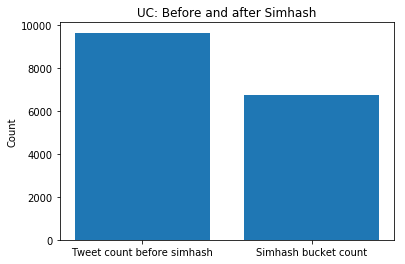

In [135]:
# Build a bar-chart visualization for two variables (count of unique and count of “near-duplicate”)
plt.bar(["Tweet count before simhash","Simhash bucket count"], [len(UC_titles_sim),len(UC_text_indexes)])
plt.ylabel('Count')
plt.title('UC: Before and after Simhash')
plt.show()

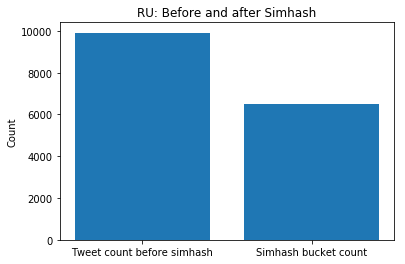

In [131]:
plt.bar(["Tweet count before simhash","Simhash bucket count"], [len(RU_titles_sim),len(RU_text_indexes)])
plt.ylabel('Count')
plt.title('RU: Before and after Simhash')
plt.show()

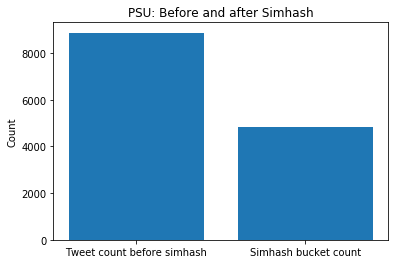

In [132]:
plt.bar(["Tweet count before simhash","Simhash bucket count"], [len(PSU_titles_sim),len(PSU_text_indexes)])
plt.ylabel('Count')
plt.title('PSU: Before and after Simhash')
plt.show()

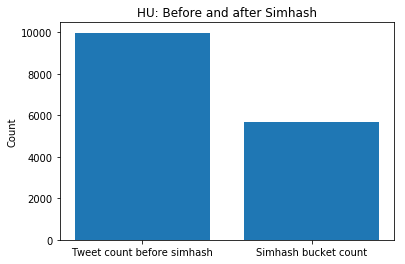

In [133]:
plt.bar(["Tweet count before simhash","Simhash bucket count"], [len(HU_titles_sim),len(HU_text_indexes)])
plt.ylabel('Count')
plt.title('HU: Before and after Simhash')
plt.show()

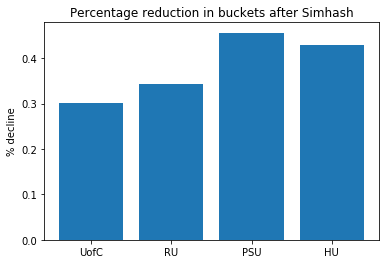

In [137]:
plt.bar(["UofC","RU","PSU","HU"], [(1-len(UC_text_indexes)/len(UC_titles_sim)),(1-len(RU_text_indexes)/len(RU_titles_sim)),(1-len(PSU_text_indexes)/len(PSU_titles_sim)),(1-len(HU_text_indexes)/len(HU_titles_sim))])
plt.ylabel('% decline')
plt.title('Percentage reduction in buckets after Simhash')
plt.show()

In [ ]:
# # Build a histogram showing the overall distribution of “near-duplication”
# UC_similar_distribution=[]
# for i in UC_flat_list:
#     if i > .8:
#        UC_similar_distribution.append(i) 
    
# plt.hist(UC_similar_distribution)
# plt.ylabel('Count')
# plt.title('Near-duplicate jaccard distribution, Simhash k=3, Jaccard N=1')
# plt.show()